## Task 5 (Transformers)

In [1]:
import torch
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from tqdm import tqdm

2025-04-10 20:16:02.194916: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 20:16:02.209353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744316162.224258    1123 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744316162.228832    1123 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744316162.242042    1123 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 1. Load dataset

In [2]:
# Load the dataset with extracted features
features = "../Task 4/balanced_classes_dataset.csv"
df1 = pd.read_csv(features)

# Display dataset structure in table format
display(df1)

,Sentence,Emotion
0,"Ce que vous ne comprenez pas, c ' est, pour no...",happiness
1,"Ouais, c ' est vrai!....... Y ' Serious?",neutral
2,Oh ouais!,happiness
3,Tout ce que vous devez savoir est dans ce prem...,happiness
4,Absolument.,happiness
...,...,...
105843,"Malheureusement, je n ' ai Pa d ' assurance, a...",fear
105844,"Ma famille ne s ' en assez jamais souciait, j ...",fear
105845,mommy Ma famille ne s ' en souciait jamais ass...,fear
105846,J ' ai fait choses dans la vraie vie et je jam...,fear


In [6]:
df1['Emotion'].value_counts()

Emotion
happiness    24583
sadness      21191
neutral      18403
anger        14834
disgust      10755
surprise     10556
fear          5526
Name: count, dtype: int64

In [7]:
import pandas as pd
from tqdm import tqdm
import nlpaug.augmenter.word as naw

# Assuming your second dataset (d1) is already loaded as df1
tqdm.pandas()

# Initialize French contextual augmenter (CamemBERT)
aug = naw.ContextualWordEmbsAug(
    model_path='camembert-base',
    action="substitute",
    device='cuda'  # Use 'cpu' if no GPU
)

# Set desired target for class size
TARGET_SIZE = 5000

# Initialize a list to hold augmented sentences
augmented_sentences = []
augmented_labels = []

# Iterate over each class and augment or sample
for emotion, count in df1['Emotion'].value_counts().items():
    print(f"Processing {emotion} class with {count} samples...")

    # Subset the data for the current emotion
    subset = df1[df1["Emotion"] == emotion]

    # If the class is 'fear', leave it untouched
    if emotion == 'fear':
        augmented_sentences.extend(subset["Sentence"].tolist())
        augmented_labels.extend([emotion] * len(subset))

    # If the class size is greater than TARGET_SIZE, sample down to TARGET_SIZE
    elif count > TARGET_SIZE:
        print(f"Sampling {emotion} class down to {TARGET_SIZE} samples...")
        augmented_sentences.extend(subset.sample(n=TARGET_SIZE, replace=False)["Sentence"].tolist())
        augmented_labels.extend([emotion] * TARGET_SIZE)

    # If the class size is less than TARGET_SIZE, augment it
    else:
        print(f"Augmenting {emotion} class...")
        augmented = subset["Sentence"].progress_apply(lambda x: aug.augment(x, n=2)[0]).tolist()
        
        # Collect augmented sentences and labels
        augmented_sentences.extend(augmented)
        augmented_labels.extend([emotion] * len(augmented))

# Create a DataFrame for the augmented data
augmented_df = pd.DataFrame({"Sentence": augmented_sentences, "Emotion": augmented_labels})

# Check the new class distribution
df_final = augmented_df.groupby("Emotion").apply(
    lambda x: x.sample(n=TARGET_SIZE, replace=False) if len(x) > TARGET_SIZE else x
).reset_index(drop=True)

print("After Augmentation and Sampling:\n", df_final["Emotion"].value_counts())

Processing happiness class with 24583 samples...
Sampling happiness class down to 5000 samples...
Processing sadness class with 21191 samples...
Sampling sadness class down to 5000 samples...
Processing neutral class with 18403 samples...
Sampling neutral class down to 5000 samples...
Processing anger class with 14834 samples...
Sampling anger class down to 5000 samples...
Processing disgust class with 10755 samples...
Sampling disgust class down to 5000 samples...
Processing surprise class with 10556 samples...
Sampling surprise class down to 5000 samples...
Processing fear class with 5526 samples...
After Augmentation and Sampling:
 Emotion
anger        5000
disgust      5000
fear         5000
happiness    5000
neutral      5000
sadness      5000
surprise     5000
Name: count, dtype: int64


In [8]:
df1=df_final

In [9]:
df2 = pd.read_csv('test_data/group 12_url1.csv')
display(df2)

,Start Time,End Time,Sentence,Corrected Sentence,Translation,Emotion,Intensity
0,"00:00:00,000","00:00:05,000","Après l'Asie, l'Afrique, les Etats-Unis et l'A...","Après l'Asie, l'Afrique, les Etats-Unis et l'A...","After Asia, Africa, the United States and Lati...",neutral,neutral
1,"00:00:05,000","00:00:08,000",les Mercedes s'envolent à plus de 16 000 kilom...,les Mercedes s'envolent à plus de 16 000 kilom...,"The Mercedes fly over 16,000 kilometers from t...",neutral,neutral
2,"00:00:08,000","00:00:10,000",et posent leur valise en Australie.,et posent leur valise en Australie.,And put their suitcase in Australia.,neutral,neutral
3,"00:00:18,000","00:00:20,000","Ensemble, ils relèvent le défi de s'imposer en...","Ensemble, ils relèvent le défi de s'imposer en...","Together, they take up the challenge of winnin...",excitement,moderate
4,"00:00:20,000","00:00:22,000",et de découvrir ce pays aussi magnifique,et de découvrir ce pays aussi magnifique,And to discover this magnificent country,curiosity,mild
...,...,...,...,...,...,...,...
1227,"00:39:38,000","00:39:39,000",You're fier de hacer de mi,You're fier de hacer de mi,You're fier to make me,pride,mild
1228,"00:39:39,000","00:39:40,000","If you leave me, my baby","If you leave me, my baby","If you leave me, my baby",fear,moderate
1229,"00:39:40,000","00:39:41,000","I need you, my cone","I need you, my cone","I need you, my cone",desire,mild
1230,"00:39:41,000","00:39:42,000",No te voyas,No te voyas,Don't go,sadness,moderate


In [10]:
df2.drop(columns=['Start Time', 'End Time', 'Sentence', 'Translation', 'Intensity'], inplace=True)

In [11]:
df2.rename(columns={'Corrected Sentence': 'Sentence'}, inplace=True)

# Rename emotions to fit with our labels
df2["Emotion"] = df2["Emotion"].str.replace("excitement", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("confusion", "surprise")
df2["Emotion"] = df2["Emotion"].str.replace("annoyance", "anger")
df2["Emotion"] = df2["Emotion"].str.replace("disapproval", "disgust")
df2["Emotion"] = df2["Emotion"].str.replace("pride", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("joy", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("disappointment", "sadness")
df2["Emotion"] = df2["Emotion"].str.replace("optimism", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("admiration", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("approval", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("nervousness", "fear")
df2["Emotion"] = df2["Emotion"].str.replace("realization", "surprise")
df2["Emotion"] = df2["Emotion"].str.replace("gratitude", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("caring", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("love", "happiness")
df2["Emotion"] = df2["Emotion"].str.replace("remorse", "sadness")
df2["Emotion"] = df2["Emotion"].str.replace("embarrassment", "fear")
df2["Emotion"] = df2["Emotion"].str.replace("grief", "sadness")

# Remove unecessary rows that add to the 'happiness' class (there are enough samples)
df2 = df2[~df2['Emotion'].isin(['curiosity', 'desire', 'relief','amusement'])]


import pandas as pd
from tqdm import tqdm
import nlpaug.augmenter.word as naw

# Load your dataset (adjust path and column names if needed)
tqdm.pandas()

# Initialize French contextual augmenter (CamemBERT)
aug = naw.ContextualWordEmbsAug(
    model_path='camembert-base',
    action="substitute",
    device='cuda'
)

# Set desired target for class size
TARGET_SIZE = 5000

# Initialize a list to hold augmented sentences
augmented_sentences = []
augmented_labels = []

# Iterate over each class and augment
for emotion, count in df2['Emotion'].value_counts().items():
    print(f"Processing {emotion} class with {count} samples...")

    # Subset the data for the current emotion
    subset = df2[df2["Emotion"] == emotion]

    # If class size is less than the target, augment it
    if count < TARGET_SIZE:
        print(f"Augmenting {emotion} class...")
        # Augment each sentence in the subset
        augmented = subset["Sentence"].progress_apply(lambda x: aug.augment(x, n=2)[0]).tolist()
        
        # Collect augmented sentences and labels
        augmented_sentences.extend(augmented)
        augmented_labels.extend([emotion] * len(augmented))

    # If the class is already above the target size, just take the original samples
    else:
        augmented_sentences.extend(subset["Sentence"].tolist())
        augmented_labels.extend([emotion] * len(subset))

# Create a DataFrame for the augmented data
augmented_df = pd.DataFrame({"Sentence": augmented_sentences, "Emotion": augmented_labels})

# If there are still more than 5000 examples for a class, randomly sample to get exactly 5000
df_final = augmented_df.groupby("Emotion").apply(
    lambda x: x.sample(n=TARGET_SIZE, replace=True) if len(x) < TARGET_SIZE else x.sample(n=TARGET_SIZE, replace=False)
).reset_index(drop=True)

# Check the new class distribution
print("After Augmentation:\n", df_final["Emotion"].value_counts())

df2 = pd.concat([df2, df_final], ignore_index=True)
df = pd.concat([df1,df2], ignore_index=True)

df.dropna(inplace=True)

Processing neutral class with 383 samples...
Augmenting neutral class...


100%|██████████| 383/383 [00:10<00:00, 35.25it/s]


Processing happiness class with 254 samples...
Augmenting happiness class...


100%|██████████| 254/254 [00:07<00:00, 35.95it/s]


Processing surprise class with 133 samples...
Augmenting surprise class...


100%|██████████| 133/133 [00:03<00:00, 36.33it/s]


Processing anger class with 98 samples...
Augmenting anger class...


100%|██████████| 98/98 [00:02<00:00, 33.17it/s]


Processing disgust class with 58 samples...
Augmenting disgust class...


100%|██████████| 58/58 [00:01<00:00, 30.79it/s]


Processing sadness class with 53 samples...
Augmenting sadness class...


100%|██████████| 53/53 [00:01<00:00, 30.70it/s]


Processing fear class with 35 samples...
Augmenting fear class...


100%|██████████| 35/35 [00:01<00:00, 30.38it/s]

After Augmentation:
 Emotion
anger        5000
disgust      5000
fear         5000
happiness    5000
neutral      5000
sadness      5000
surprise     5000
Name: count, dtype: int64


In [12]:
# Save cleaned dataset
cleaned_file_path = "../Task 4/final_dataset.csv"
df.to_csv(cleaned_file_path, index=False, encoding="utf-8")

---

### 2. Processing the features

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

# Encode emotion labels
label_encoder_emotion = LabelEncoder()
df["emotion_label"] = label_encoder_emotion.fit_transform(df["Emotion"])

---

### 3. Models

### Transformer 1: BERT

#### Trial 1

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Tokenize the sentences using BERT's tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Modify the function to return a dictionary
def encode_sentences(sentences):
    return tokenizer(sentences.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Tokenize the sentences
encoded_inputs = encode_sentences(df['Sentence'])

# Extract input_ids and attention_mask separately
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Now, split data correctly
X_train, X_val, attn_train, attn_val, y_train, y_val = train_test_split(
    input_ids, attention_mask, df['emotion_label'], test_size=0.2, random_state=42
)

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from transformers import get_scheduler

# Convert to tensors
train_inputs = torch.tensor(X_train).clone().detach()
val_inputs = torch.tensor(X_val).clone().detach()
train_attn = torch.tensor(attn_train).clone().detach()
val_attn = torch.tensor(attn_val).clone().detach()
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# Create DataLoader for batch processing
train_data = TensorDataset(train_inputs, train_attn, train_labels)
val_data = TensorDataset(val_inputs, val_attn, val_labels)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder_emotion.classes_))

# Setup optimizer
optimizer = AdamW(model.parameters(), weight_decay=0.01)

# Move model to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping Parameters
patience = 3  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

num_training_steps = len(train_dataloader) * 10  # Assuming 10 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Training loop
for epoch in range(15):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/10", unit="batch", leave=False)
    
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer
        optimizer.step()
        lr_scheduler.step()  # Adjust learning rate dynamically

        # Update progress bar
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1), refresh=True)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch  
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
        
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1  # Increase counter

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Stopping training.")
        break

/tmp/ipykernel_12831/1048416070.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(X_train).clone().detach()
/tmp/ipykernel_12831/1048416070.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(X_val).clone().detach()
/tmp/ipykernel_12831/1048416070.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attn = torch.tensor(attn_train).clone().detach()
/tmp/ipykernel_12831/1048416070.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

Epoch 1, Training Loss: 1.9090
Epoch 1, Validation Loss: 1.8833


Epoch 2, Training Loss: 1.8765
Epoch 2, Validation Loss: 1.8791


Epoch 3, Training Loss: 1.8706
Epoch 3, Validation Loss: 1.8735


Epoch 4, Training Loss: 1.8681
Epoch 4, Validation Loss: 1.8590


Epoch 5, Training Loss: 1.8667
Epoch 5, Validation Loss: 1.8670


Epoch 6, Training Loss: 1.8646
Epoch 6, Validation Loss: 1.8682


Epoch 7, Training Loss: 1.8623
Epoch 7, Validation Loss: 1.8630
Early stopping triggered. Stopping training.


In [14]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate the model on the validation set
model.eval()
val_preds = []
val_labels_list = []

# Validation loop with tqdm progress bar
progress_bar = tqdm(val_dataloader, desc="Evaluating", unit="batch")
for batch in progress_bar:
    input_ids, attention_mask, labels = batch  
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    val_preds.extend(preds.cpu().numpy())
    val_labels_list.extend(labels.cpu().numpy())

# Convert the predictions and true labels back to the original class labels
val_preds_str = label_encoder_emotion.inverse_transform(val_preds)
val_labels_str = label_encoder_emotion.inverse_transform(val_labels_list)

# Calculate accuracy
accuracy = accuracy_score(val_labels_str, val_preds_str)
print(f"Accuracy: {accuracy}")

# Calculate F1 Score (Macro Average)
f1 = f1_score(val_labels_str, val_preds_str, average='macro')
print(f"F1 Score (Macro Average): {f1}")

# Generate classification report
report = classification_report(val_labels_str, val_preds_str, target_names=label_encoder_emotion.classes_)
print("Classification Report:")
print(report)

Evaluating: 100%|██████████| 331/331 [00:23<00:00, 14.10batch/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.2290977798771847
F1 Score (Macro Average): 0.05325573734489953
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      2876
     disgust       0.00      0.00      0.00      2181
        fear       0.00      0.00      0.00      1080
   happiness       0.23      1.00      0.37      4850
     neutral       0.00      0.00      0.00      3756
     sadness       0.00      0.00      0.00      4265
    surprise       0.00      0.00      0.00      2162

    accuracy                           0.23     21170
   macro avg       0.03      0.14      0.05     21170
weighted avg       0.05      0.23      0.09     21170



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


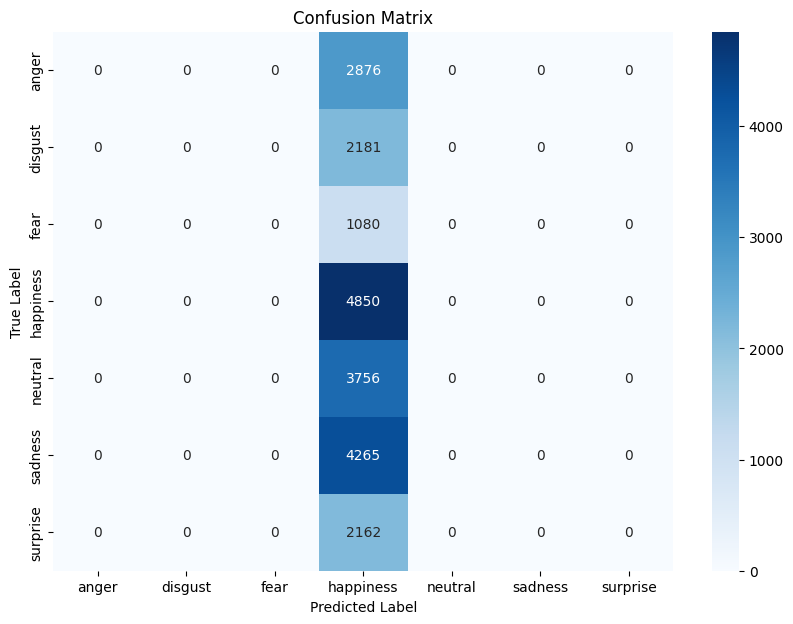

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(val_labels_str, val_preds_str)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder_emotion.classes_, yticklabels=label_encoder_emotion.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Trial 2

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Tokenize the sentences using BERT's tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Modify the function to return a dictionary
def encode_sentences(sentences):
    return tokenizer(sentences.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Tokenize the sentences
encoded_inputs = encode_sentences(df['Sentence'])

# Extract input_ids and attention_mask separately
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Now, split data correctly
X_train, X_val, attn_train, attn_val, y_train, y_val = train_test_split(
    input_ids, attention_mask, df['emotion_label'], test_size=0.2, random_state=42
)

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from transformers import get_scheduler

# Convert to tensors
train_inputs = torch.tensor(X_train).clone().detach()
val_inputs = torch.tensor(X_val).clone().detach()
train_attn = torch.tensor(attn_train).clone().detach()
val_attn = torch.tensor(attn_val).clone().detach()
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# Create DataLoader for batch processing
train_data = TensorDataset(train_inputs, train_attn, train_labels)
val_data = TensorDataset(val_inputs, val_attn, val_labels)

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder_emotion.classes_))

# Setup optimizer
optimizer = AdamW(model.parameters(),lr=2e-5, weight_decay=0.01)

# Move model to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping Parameters
patience = 3  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

num_training_steps = len(train_dataloader) * 10  # Assuming 10 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Training loop
for epoch in range(15):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/10", unit="batch", leave=False)
    
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer
        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1), refresh=True)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch  
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
        
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1  # Increase counter

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Stopping training.")
        break

/tmp/ipykernel_19729/3415802966.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(X_train).clone().detach()
/tmp/ipykernel_19729/3415802966.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(X_val).clone().detach()
/tmp/ipykernel_19729/3415802966.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attn = torch.tensor(attn_train).clone().detach()
/tmp/ipykernel_19729/3415802966.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

Epoch 1, Training Loss: 1.4267
Epoch 1, Validation Loss: 1.2795


Epoch 2, Training Loss: 1.1195
Epoch 2, Validation Loss: 1.1091


Epoch 3, Training Loss: 0.8022
Epoch 3, Validation Loss: 1.0023


Epoch 4, Training Loss: 0.5540
Epoch 4, Validation Loss: 0.9153


Epoch 5, Training Loss: 0.4161
Epoch 5, Validation Loss: 0.8874


Epoch 6, Training Loss: 0.3291
Epoch 6, Validation Loss: 0.9796


Epoch 7, Training Loss: 0.2810
Epoch 7, Validation Loss: 0.9563


Epoch 8, Training Loss: 0.2442
Epoch 8, Validation Loss: 1.1069
Early stopping triggered. Stopping training.


In [7]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate the model on the validation set
model.eval()
val_preds = []
val_labels_list = []

# Validation loop with tqdm progress bar
progress_bar = tqdm(val_dataloader, desc="Evaluating", unit="batch")
for batch in progress_bar:
    input_ids, attention_mask, labels = batch  
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    val_preds.extend(preds.cpu().numpy())
    val_labels_list.extend(labels.cpu().numpy())

# Convert the predictions and true labels back to the original class labels
val_preds_str = label_encoder_emotion.inverse_transform(val_preds)
val_labels_str = label_encoder_emotion.inverse_transform(val_labels_list)

# Calculate accuracy
accuracy = accuracy_score(val_labels_str, val_preds_str)
print(f"Accuracy: {accuracy}")

# Calculate F1 Score (Macro Average)
f1 = f1_score(val_labels_str, val_preds_str, average='macro')
print(f"F1 Score (Macro Average): {f1}")

# Generate classification report
report = classification_report(val_labels_str, val_preds_str, target_names=label_encoder_emotion.classes_)
print("Classification Report:")
print(report)

Evaluating: 100%|██████████| 1324/1324 [00:23<00:00, 56.82batch/s]


Accuracy: 0.7596126594237128
F1 Score (Macro Average): 0.7498330798974614
Classification Report:
              precision    recall  f1-score   support

       anger       0.84      0.78      0.81      2876
     disgust       0.85      0.83      0.84      2181
        fear       0.75      0.79      0.77      1080
   happiness       0.69      0.69      0.69      4850
     neutral       0.79      0.83      0.81      3756
     sadness       0.80      0.88      0.84      4265
    surprise       0.55      0.45      0.49      2162

    accuracy                           0.76     21170
   macro avg       0.75      0.75      0.75     21170
weighted avg       0.76      0.76      0.76     21170



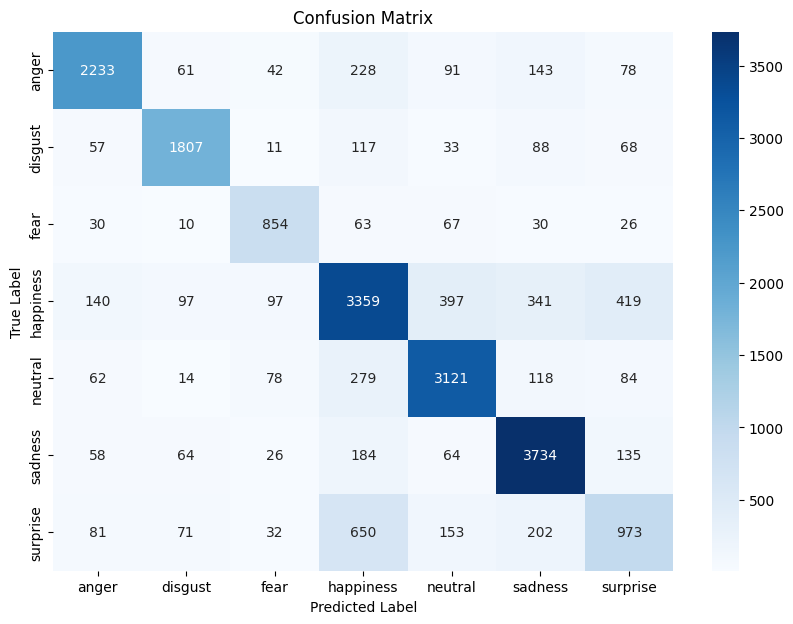

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(val_labels_str, val_preds_str)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder_emotion.classes_, yticklabels=label_encoder_emotion.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Trial 3

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Tokenize the sentences using BERT's tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Modify the function to return a dictionary
def encode_sentences(sentences):
    return tokenizer(sentences.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Tokenize the sentences
encoded_inputs = encode_sentences(df['Sentence'])

# Extract input_ids and attention_mask separately
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Now, split data correctly
X_train, X_val, attn_train, attn_val, y_train, y_val = train_test_split(
    input_ids, attention_mask, df['emotion_label'], test_size=0.2, random_state=42
)

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define weighted loss function
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from transformers import get_scheduler

# Convert to tensors
train_inputs = torch.tensor(X_train).clone().detach()
val_inputs = torch.tensor(X_val).clone().detach()
train_attn = torch.tensor(attn_train).clone().detach()
val_attn = torch.tensor(attn_val).clone().detach()
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# Create DataLoader for batch processing
train_data = TensorDataset(train_inputs, train_attn, train_labels)
val_data = TensorDataset(val_inputs, val_attn, val_labels)

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_encoder_emotion.classes_))

# Setup optimizer
optimizer = AdamW(model.parameters(),lr=2e-5, weight_decay=0.01)

# Move model to GPU 
device = torch.device("cuda")
model.to(device)

# Early Stopping Parameters
patience = 2  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

num_training_steps = len(train_dataloader) * 10  # Assuming 10 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Model loop
for epoch in range(15):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/15", unit="batch", leave=False)

    # Training phase
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Extract logits

        # Compute weighted loss
        loss = loss_function(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer
        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1), refresh=True)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    
    loss_function = torch.nn.CrossEntropyLoss()  # No class weights for validation
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch  
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
        
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_function(outputs.logits, labels)  # Explicit loss calculation
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")


    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1  # Increase counter

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Stopping training.")
        break

    # Save the model
    model.save_pretrained('./bert_model_6')
    
    # Save the tokenizer
    tokenizer.save_pretrained('./bert_model_6')


/tmp/ipykernel_41162/1692020511.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(X_train).clone().detach()
/tmp/ipykernel_41162/1692020511.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(X_val).clone().detach()
/tmp/ipykernel_41162/1692020511.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attn = torch.tensor(attn_train).clone().detach()
/tmp/ipykernel_41162/1692020511.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

Epoch 1, Training Loss: 1.4367
Epoch 1, Validation Loss: 1.3245


Epoch 2, Training Loss: 1.1182
Epoch 2, Validation Loss: 1.1315


Epoch 3, Training Loss: 0.8577
Epoch 3, Validation Loss: 1.0324


Epoch 4, Training Loss: 0.6214
Epoch 4, Validation Loss: 0.9104


Epoch 5, Training Loss: 0.4730
Epoch 5, Validation Loss: 0.8900


Epoch 6, Training Loss: 0.3835
Epoch 6, Validation Loss: 0.8961


Epoch 7, Training Loss: 0.3263
Epoch 7, Validation Loss: 0.8943
Early stopping triggered. Stopping training.


In [13]:
import joblib
joblib.dump(label_encoder_emotion, "label_encoder.pkl")

['label_encoder.pkl']

In [9]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate the model on the validation set
model.eval()
val_preds = []
val_labels_list = []

# Validation loop with tqdm progress bar
progress_bar = tqdm(val_dataloader, desc="Evaluating", unit="batch")
for batch in progress_bar:
    input_ids, attention_mask, labels = batch  
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    val_preds.extend(preds.cpu().numpy())
    val_labels_list.extend(labels.cpu().numpy())

# Convert the predictions and true labels back to the original class labels
val_preds_str = label_encoder_emotion.inverse_transform(val_preds)
val_labels_str = label_encoder_emotion.inverse_transform(val_labels_list)

# Calculate accuracy
accuracy = accuracy_score(val_labels_str, val_preds_str)
print(f"Accuracy: {accuracy}")

# Calculate F1 Score (Macro Average)
f1 = f1_score(val_labels_str, val_preds_str, average='macro')
print(f"F1 Score (Macro Average): {f1}")

# Generate classification report
report = classification_report(val_labels_str, val_preds_str, target_names=label_encoder_emotion.classes_)
print("Classification Report:")
print(report)

Evaluating: 100%|██████████| 1324/1324 [00:22<00:00, 59.10batch/s]


Accuracy: 0.7512045347189419
F1 Score (Macro Average): 0.7472252032756656
Classification Report:
              precision    recall  f1-score   support

       anger       0.77      0.80      0.78      2876
     disgust       0.84      0.84      0.84      2181
        fear       0.78      0.75      0.76      1080
   happiness       0.72      0.66      0.69      4850
     neutral       0.76      0.84      0.80      3756
     sadness       0.84      0.81      0.82      4265
    surprise       0.52      0.56      0.53      2162

    accuracy                           0.75     21170
   macro avg       0.75      0.75      0.75     21170
weighted avg       0.75      0.75      0.75     21170



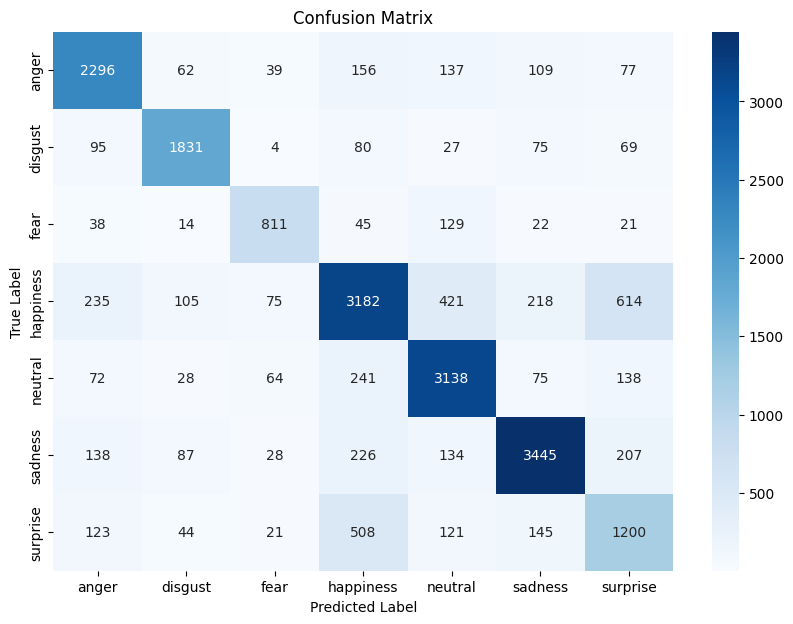

In [11]:
# import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(val_labels_str, val_preds_str)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder_emotion.classes_, yticklabels=label_encoder_emotion.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

---

## Transformer 2: CamemBERT

### Trial 1

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_scheduler

# Load Camembert tokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Function to encode sentences
def encode_sentences(sentences):
    return tokenizer(sentences.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Tokenize dataset
encoded_inputs = encode_sentences(df["Sentence"])
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Train-test split
X_train, X_val, attn_train, attn_val, y_train, y_val = train_test_split(
    input_ids, attention_mask, df["emotion_label"], test_size=0.2, random_state=42
)

# Compute class weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define weighted loss function
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)

# Convert to tensors
train_inputs = torch.tensor(X_train).clone().detach()
val_inputs = torch.tensor(X_val).clone().detach()
train_attn = torch.tensor(attn_train).clone().detach()
val_attn = torch.tensor(attn_val).clone().detach()
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# Create DataLoader for batch processing
batch_size = 16  # Change this based on your GPU memory
train_data = TensorDataset(train_inputs, train_attn, train_labels)
val_data = TensorDataset(val_inputs, val_attn, val_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Load Camembert model for classification
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=len(label_encoder_emotion.classes_))

# Freeze lower layers for efficiency
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False
for param in model.roberta.encoder.layer[:6].parameters():  # Freeze first 6 layers
    param.requires_grad = False

# Move model to GPU
model.to(device)

# Setup optimizer
optimizer = Adam(model.parameters(), lr=2e-5)  # Trying Adam instead of AdamW

# Learning rate scheduler with warmup
num_training_steps = len(train_dataloader) * 10  # Assuming 10 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps
)

# Early Stopping Parameters
patience = 2
best_val_loss = float("inf")
epochs_no_improve = 0

# Training Loop
for epoch in range(15):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/15", unit="batch", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute weighted loss
        loss = loss_function(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1), refresh=True)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_function(outputs.logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Stopping training.")
        break

    # Save the model
    model.save_pretrained("./camembert_model_5")
    tokenizer.save_pretrained("./camembert_model_5")

/tmp/ipykernel_41162/4091720355.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(X_train).clone().detach()
/tmp/ipykernel_41162/4091720355.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(X_val).clone().detach()
/tmp/ipykernel_41162/4091720355.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attn = torch.tensor(attn_train).clone().detach()
/tmp/ipykernel_41162/4091720355.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

Epoch 1, Training Loss: 1.9478
Epoch 1, Validation Loss: 1.9481


Epoch 2, Training Loss: 1.9478
Epoch 2, Validation Loss: 1.9481


Epoch 3, Training Loss: 1.9479
Epoch 3, Validation Loss: 1.9481
Early stopping triggered. Stopping training.


In [14]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate the model on the validation set
model.eval()
val_preds = []
val_labels_list = []

# Validation loop with tqdm progress bar
progress_bar = tqdm(val_dataloader, desc="Evaluating", unit="batch")
for batch in progress_bar:
    input_ids, attention_mask, labels = batch  
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    val_preds.extend(preds.cpu().numpy())
    val_labels_list.extend(labels.cpu().numpy())

# Convert the predictions and true labels back to the original class labels
val_preds_str = label_encoder_emotion.inverse_transform(val_preds)
val_labels_str = label_encoder_emotion.inverse_transform(val_labels_list)

# Calculate accuracy
accuracy = accuracy_score(val_labels_str, val_preds_str)
print(f"Accuracy: {accuracy}")

# Calculate F1 Score (Macro Average)
f1 = f1_score(val_labels_str, val_preds_str, average='macro')
print(f"F1 Score (Macro Average): {f1}")

# Generate classification report
report = classification_report(val_labels_str, val_preds_str, target_names=label_encoder_emotion.classes_)
print("Classification Report:")
print(report)

Evaluating: 100%|██████████| 1324/1324 [00:19<00:00, 68.07batch/s]


Accuracy: 0.13396315540859707
F1 Score (Macro Average): 0.034754530315235115
Classification Report:
              precision    recall  f1-score   support

       anger       0.14      0.98      0.24      2876
     disgust       0.00      0.00      0.00      2181
        fear       0.01      0.00      0.00      1080
   happiness       0.00      0.00      0.00      4850
     neutral       1.00      0.00      0.00      3756
     sadness       0.00      0.00      0.00      4265
    surprise       0.00      0.00      0.00      2162

    accuracy                           0.13     21170
   macro avg       0.16      0.14      0.03     21170
weighted avg       0.20      0.13      0.03     21170



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


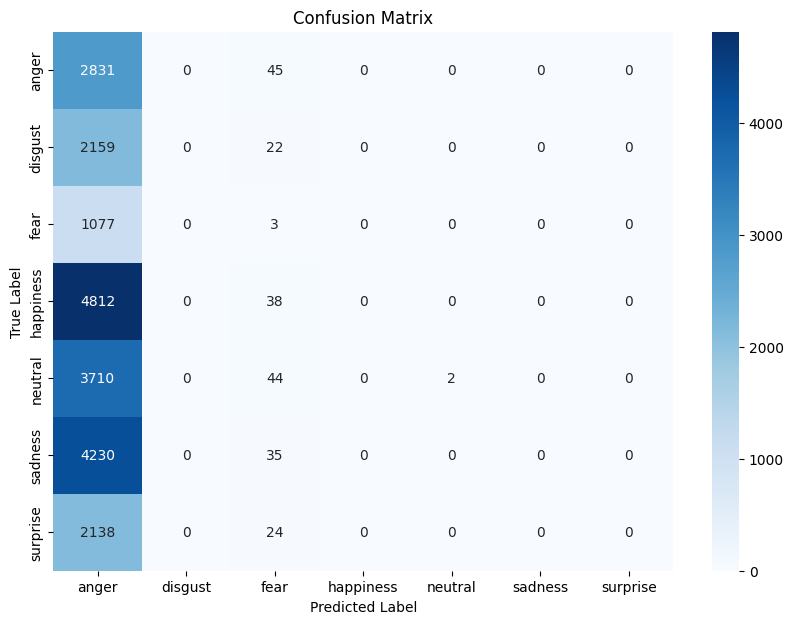

In [15]:
# import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(val_labels_str, val_preds_str)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder_emotion.classes_, yticklabels=label_encoder_emotion.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Trial 2

In [13]:
label_encoder_camembert = LabelEncoder()
df["emotion_label"] = label_encoder_camembert.fit_transform(df["Emotion"])

In [14]:
label_encoder_camembert.classes_

array(['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness',
       'surprise'], dtype=object)

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import CamembertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from transformers import get_scheduler

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer

# Tokenize the sentences using BERT's tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Modify the function to return a dictionary
def encode_sentences(sentences):
    return tokenizer(sentences.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Tokenize the sentences
encoded_inputs = encode_sentences(df['Sentence'])

# Extract input_ids and attention_mask separately
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Now, split data correctly
X_train, X_val, attn_train, attn_val, y_train, y_val = train_test_split(
    input_ids, attention_mask, df['emotion_label'], test_size=0.2, random_state=42
)

# Convert to tensors
train_inputs = torch.tensor(X_train).clone().detach()
val_inputs = torch.tensor(X_val).clone().detach()
train_attn = torch.tensor(attn_train).clone().detach()
val_attn = torch.tensor(attn_val).clone().detach()
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# Create DataLoader for batch processing
train_data = TensorDataset(train_inputs, train_attn, train_labels)
val_data = TensorDataset(val_inputs, val_attn, val_labels)

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16)

# Load the pre-trained CamemBERT model for sequence classification
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder_emotion.classes_))

# Setup optimizer
optimizer = AdamW(model.parameters(),lr=2e-5, weight_decay=0.01)

# Move model to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping Parameters
patience = 3  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

num_training_steps = len(train_dataloader) * 10  # Assuming 10 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Training loop
for epoch in range(15):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/10", unit="batch", leave=False)
    
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer
        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1), refresh=True)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch  
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
        
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1  # Increase counter

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Stopping training.")
        break


/tmp/ipykernel_122271/684263540.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(X_train).clone().detach()
/tmp/ipykernel_122271/684263540.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(X_val).clone().detach()
/tmp/ipykernel_122271/684263540.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attn = torch.tensor(attn_train).clone().detach()
/tmp/ipykernel_122271/684263540.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

Epoch 1, Training Loss: 0.9774
Epoch 1, Validation Loss: 0.6960


Epoch 2, Training Loss: 0.6131
Epoch 2, Validation Loss: 0.6606


Epoch 3, Training Loss: 0.4714
Epoch 3, Validation Loss: 0.6786


Epoch 4, Training Loss: 0.3453
Epoch 4, Validation Loss: 0.6981


Epoch 5, Training Loss: 0.2576
Epoch 5, Validation Loss: 0.8266
Early stopping triggered. Stopping training.


In [26]:
model.save_pretrained("./camembert_model_6")

In [19]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate the model on the validation set
model.eval()
val_preds = []
val_labels_list = []

# Validation loop with tqdm progress bar
progress_bar = tqdm(val_dataloader, desc="Evaluating", unit="batch")
for batch in progress_bar:
    input_ids, attention_mask, labels = batch  
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    val_preds.extend(preds.cpu().numpy())
    val_labels_list.extend(labels.cpu().numpy())

# Convert the predictions and true labels back to the original class labels
val_preds_str = label_encoder_emotion.inverse_transform(val_preds)
val_labels_str = label_encoder_emotion.inverse_transform(val_labels_list)

# Calculate accuracy
accuracy = accuracy_score(val_labels_str, val_preds_str)
print(f"Accuracy: {accuracy}")

# Calculate F1 Score (Macro Average)
f1 = f1_score(val_labels_str, val_preds_str, average='macro')
print(f"F1 Score (Macro Average): {f1}")

# Generate classification report
report = classification_report(val_labels_str, val_preds_str, target_names=label_encoder_emotion.classes_)
print("Classification Report:")
print(report)

Evaluating: 100%|██████████| 888/888 [00:13<00:00, 67.84batch/s]


Accuracy: 0.7890586495810744
F1 Score (Macro Average): 0.7891693007802975
Classification Report:
              precision    recall  f1-score   support

       anger       0.73      0.76      0.75      2039
     disgust       0.91      0.78      0.84      2015
        fear       0.78      0.92      0.84      1970
   happiness       0.72      0.82      0.77      2069
     neutral       0.80      0.77      0.78      2124
     sadness       0.79      0.77      0.78      2017
    surprise       0.85      0.70      0.77      1969

    accuracy                           0.79     14203
   macro avg       0.80      0.79      0.79     14203
weighted avg       0.79      0.79      0.79     14203



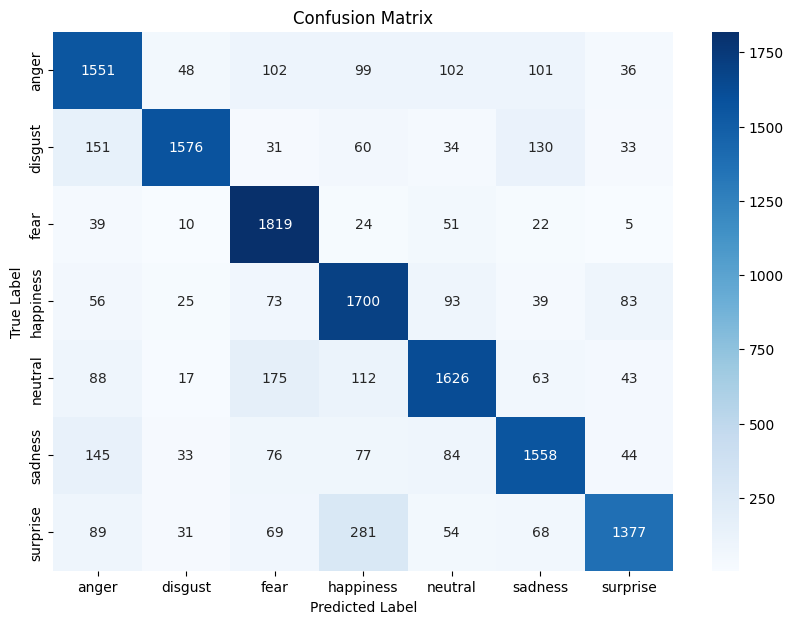

In [22]:
# import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Plot confusion matrix
cm = confusion_matrix(val_labels_str, val_preds_str)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder_emotion.classes_, yticklabels=label_encoder_emotion.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

#### Testing on unseen data

In [25]:
# Assuming you have a test dataframe 'df_test' that contains 'Sentence' and 'Emotion' columns:
df_test = pd.read_csv("test_data/transformers_test_dataset.csv")  # Adjust the path to your test dataset

# Encode the test labels (you don't need to save the label encoder as you're using it in the same notebook)
df_test["emotion_label"] = label_encoder_camembert.transform(df_test["Emotion"])

# Tokenize the test sentences using the same tokenizer you used for training (CamembertTokenizer)
encoded_test_inputs = encode_sentences(df_test['Sentence'])

# Extract input_ids and attention_mask for the test set
test_input_ids = encoded_test_inputs["input_ids"]
test_attention_mask = encoded_test_inputs["attention_mask"]

# Convert to tensors
test_inputs = torch.tensor(test_input_ids).clone().detach()
test_attn = torch.tensor(test_attention_mask).clone().detach()
test_labels = torch.tensor(df_test['emotion_label'].values)

# Create a DataLoader for batch processing on the test set
test_data = TensorDataset(test_inputs, test_attn, test_labels)
test_dataloader = DataLoader(test_data, batch_size=16)

# The model is already loaded in the notebook, so no need to reload it again
model.eval()  # Set the model to evaluation mode

test_loss = 0
correct_predictions = 0
total_predictions = 0
predicted_labels_list = []  # To store all predictions
true_labels_list = []      # To store all true labels

with torch.no_grad():  # Disable gradient calculation to save memory
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()

        # Get predicted labels (class with the highest logit value)
        predictions = torch.argmax(logits, dim=-1)

        # Accumulate predictions and true labels
        predicted_labels_list.extend(predictions.cpu().numpy())
        true_labels_list.extend(labels.cpu().numpy())

        # Track the number of correct predictions
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

# Convert lists to numpy arrays for metric calculations
predicted_labels = np.array(predicted_labels_list)
true_labels = np.array(true_labels_list)

# Calculate the average test loss and accuracy
avg_test_loss = test_loss / len(test_dataloader)
accuracy = correct_predictions / total_predictions

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute Precision, Recall, F1 Score
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

/tmp/ipykernel_122271/1523800437.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_input_ids).clone().detach()
/tmp/ipykernel_122271/1523800437.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_attn = torch.tensor(test_attention_mask).clone().detach()


Test Loss: 1.8041
Test Accuracy: 63.09%
Precision: 0.6353
Recall: 0.6309
F1-Score: 0.6264
